# Introduction

Scholar is a framework for document modeling, much like LDA, but with the ability to flexibly incorporate metadata, with some similarity to the structural topic model. It can scale to large numbers of covariates, runs in python, and offers GPU support for fast exploration of a corpus of documents.

In this tutorial, we'll use a toy corpus of political press releases in order to demonstrate the functionality and interface of Scholar.

# Setup

### Code

If you're looking at this tutorial, you have presumably already downloaded/cloned the Scholar repo. If not, you can clone it using: 

`git clone git@github.com:dallascard/scholar.git`

(if you don't have git set up, you can just download the repo from https://github.com/dallascard/scholar)

Scholar has not yet been packaged us as a full python packge. As such, we will just run commands from the scholar directory, so switch into it:

`cd /path/to/scholar`

(the directory that contains this notebook)

### Environment

Create new python environment for running scholar. We recommend using Anaconda, but it is also possible to do this using virtualenv and pip. Assuming you are using conda, run the following three commands, one at a time, and follow the prompts:

`conda create -n scholar python=3`

`source activate scholar`

`conda install ipython notebook numpy scipy pandas matplotlib gensim pytorch torchvision -c pytorch`

You should also now quit this notebook and reload it from with the scholar environment (i.e. after running `source activate scholar` in the shell).

### Data

For this tutorial, we'll be using a subset of the Congressional press release corpus created by Justin Grimmer.

A compressed file with press releases from six senators can be found in this repo. To expand it, run

`tar -xzf tutorial.tar.gz`

which will create a  directory called  `tutorial/CongressPressExpand/`

For those who are interested, the full dataset (Press.tar; 282Mb) can be downloaded from https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/14596

# Data Import

To use scholar, it is necessary to get the data into the proper format. To do this, the easiest thing to do is to write a script to convert the documents into a single file, where each line corresponds to one document, represented as a JSON object. Each JSON object should have at least one field called "text", but it can also contain other metadata fields.

We have included a script to convert a subset of the Senatorial press releases into this format, which can be used as a starting point for your own project.

If running this from the command line, it would be run as

`python import_congress_press.py tutorial/CongressPressExpand tutorial/congress/`

Since we are running this in a notebook, we will run it by importing the package, and calling the `main()` function with the corresponding arguments in a list.

In [2]:
import import_congress_press
script = 'import_congress_press'
args = 'tutorial/CongressPressExpand tutorial/congress'
print("python", script, args)
import_congress_press.main(args.split())

python import_congress_press tutorial/CongressPressExpand tutorial/congress
274 files from Sanders
709 files from Obama
358 files from Klobuchar
293 files from McCain
614 files from Graham
235 files from Coburn
Saving files to tutorial/congress
Done!


This creates two files in the output directory (`/tutorial/congress/`):
- `train.jsonlist` contains one press release per line, in JSON format, including fields for the text of the press release, as well as senator name, party, date, year, and month
- `train.score.csv` contains DW-nominate scores for 6 senators from the 110th congress, with one score for each document in `train.jsonlist` (in the same order).

To inspect a document, we can use the `json` library to load it

In [3]:
import os
import json
with open(os.path.join('tutorial', 'congress', 'train.jsonlist')) as f:
    lines = f.readlines()
first_doc = json.loads(lines[0])
for key, value in first_doc.items():
    print(key, ':', value)

id : 10Apr2007Sanders238.txt
text : SEIZE THE OPPORTUNITY FOR MAJOR BREAKTHROUGHS IN HEALTH CARE   The Senate this week is considering a bill, cosponsored by Sen. Bernie Sanders, that would expand and encourage federal funding of human embryonic stem cell research. President Bush in 2001 cut off federal funding for research involving new embryonic stem cells, which has dramatically stalled this critical area of medical research.      "My hope is that, as a result of increased pressure from scientists, physicians and the American people, the president will change his position or, if he does not, that the Congress will have enough votes to override his veto and establish unrestricted federal funding for stem cell research," Sanders said. "The potential is now available for major breakthroughs in Parkinson's disease, Alzheimer's, diabetes, spinal cord injury, stroke, heart disease and many other illnesses. We must seize the opportunity."     View a copy of the Bill - S. 5 at http://sander

If we had documents that we wanted to use as a test set, we could create a `test.jsonlist` object in the same manner.

# Preprocessing

The next step is to use a preprocessing script we have provided to convert the documents from JSON format into a numerical representation. It works by creating a vocabulary, filtering out numbers, punctuation, and some other tokens, and saving the document-term count matrix. 

The preprocessing script can also simultaneously pull out various metadata attributes (like author or year) from the JSON objects, and convert them into one-hot representations, which will be saved as .csv files.

For other types of metadata, such as continously-valued data, you will need to create the corresponding .csv files manually, as we did above for `train.score.csv`. All that matters is that the order of the rows is the same as the the order of documents in `train.jsonlist`. Also, scholar will expect the file name to be `train.field_name.csv` (or "test" rather than "train" for test data).

To see the full set of options for any command, try running it with the `-h` option. Again, in the shell, this would be run as:

`python preprocess_data.py -h`

In [4]:
import preprocess_data
args = '-h'
print("python preprocess_data.py -h")
preprocess_data.main([args])

python preprocess_data.py -h
Usage: ipykernel_launcher.py train.jsonlist output_dir

Options:
  -h, --help            show this help message and exit
  --label=LABEL         field(s) to use as label (comma-separated):
                        default=none
  --test=TEST           Test data (test.jsonlist): default=none
  --train-prefix=TRAIN_PREFIX
                        Output prefix for training data: default=train
  --test-prefix=TEST_PREFIX
                        Output prefix for test data: default=test
  --stopwords=STOPWORDS
                        List of stopwords to exclude [None|mallet|snowball]:
                        default=snowball
  --min-doc-count=MIN_DOC_COUNT
                        Exclude words that occur in less than this number of
                        documents
  --max-doc-freq=MAX_DOC_FREQ
                        Exclude words that occur in more than this proportion
                        of documents
  --keep-num            Keep tokens made of only numbers

SystemExit: 0

/Users/dcard/anaconda/envs/pytorch4/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Here, we'll tell it to only use words that occur in at least 90 documents, which will give us a vocabulary of about 1000 words (excluding stopwords). This will help the model run faster, but using a larger vocabulary (2000 or 5000 words, might lead to much richer topics). Alternatively, we could set the vocabulary size directly, using `--vocab-size`

We'll also tell it to create the label matrices for the various metadata attributes, which we provide in a comma-separated list (without spaces). As a reminder, it will assume that each of these metadata names will be a field in each JSON document object.

In [5]:
script = 'preprocess_data.py'
args = 'tutorial/congress/train.jsonlist tutorial/congress --min-doc-count 90 --label senator,party,year,month,date'
print("python", script, args)
preprocess_data.main(args.split())

python preprocess_data.py tutorial/congress/train.jsonlist tutorial/congress --min-doc-count 90 --label senator,party,year,month,date
Using snowball stopwords
Reading data files
Found 2483 training documents
Found label senator with 6 classes
Found label party with 2 classes
Found label year with 4 classes
Found label month with 12 classes
Found label date with 918 classes
Parsing 2483 documents
Size of full vocabulary=22131
Selecting the vocabulary
Vocab size after filtering = 1021
Final vocab size = 1021
Most common words remaining: senator washington today said senate contact press also current date
Converting to count representations
Size of train document-term matrix: (2483, 1021)
0 words missing from training data
Done!


This preprocessing script creates several files, some uesd by Scholar, and some designed for other software, like Mallet. The files of interest are:
- `train.npz`, which contains a (D x V) sparse matrix of document word counts,
- `train.vocab.json`, which contains the vocabualry as a JSON object, and;
- files like `train.year.csv`, which contain the year corresponding to each document, in a matrix of size (D x C), where C is the number of distinct covariate values (e.g. years)

Let's look at a couple of files:

In [6]:
# load the vocabualry
with open(os.path.join('tutorial', 'congress', 'train.vocab.json')) as f:
    vocab = json.load(f)
print("First few words in the vocbulary:")
print(vocab[:6] + ['...'])

First few words in the vocbulary:
['ability', 'able', 'abuse', 'access', 'according', 'accountability', '...']


In [7]:
# load a covariate file
import pandas as pd
print("Start of a covariate file (train.year.csv):")
df = pd.read_csv(os.path.join('tutorial', 'congress', 'train.year.csv'), header=0, index_col=0)
print(df.head())

Start of a covariate file (train.year.csv):
                         2005  2006  2007  2008
10Apr2007Sanders238.txt     0     0     1     0
10Apr2008Sanders2.txt       0     0     0     1
10Apr2008Sanders3.txt       0     0     0     1
10Dec2007Sanders61.txt      0     0     1     0
10May2007Sanders212.txt     0     0     1     0


Note that if we had a test corpus, we could simultaneously process it by adding the `--test` option to our call to `preprocess_data` (with the path to `test.jsonlist`).

# Running Scholar

We are now ready to run Scholar!

To start off, let's just run a basic topic model, without any metadata. We just need to specify the input directory,  and it will look for the `train.npz` file, as well as `train.vocab.json`. 

Here, we'll also tell it to use 10 topics (`-k`), tell it only to run for 50 epochs (`--epochs 50`), and to use a random 1/10th of the data as a dev/validation set to monitor the fit (`--dev-folds 10`). 

In [22]:
import run_scholar
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 50 --dev-folds 10 --seed 99'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 50 --dev-folds 10 --seed 99
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Computing background frequencies
Min/max word counts in training data: 88 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 0
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 cost= 1123.892300668
Epoch: 10; Dev perplexity = inf
Epoch: 20 cost= 1109.053324245
Epoch: 20; Dev perplexity = 78207346.2447
Epoch: 30 cost= 1124.218160130
Epoch: 30; Dev perplexity = 1221.7934
Epoch: 40 cost= 1108.377098408
Epoch: 40; Dev perplexity = 784.0064
Background frequencies of top words:
senator obama bill said senate today washington graham press president
[0.01296816 0.01271263 0.00941629 0.00862415 0.00805176 0.00681244
 0.00638571 0.00630138 0.00

To display this a bit more cleanly, let's load the output and look at it.

By default, the output of the model is saved to a directory called `output`, but that can be changed using the `-o` option (remember to use `-h` to see all options).

First, let's inspect the background frequencies of the most common words (the log-frequencies are computed and saved)

In [23]:
import json
import numpy as np

# load the background log-frequencies
bg = np.load('output/bg.npz')['bg']

# load the vocabualry
with open('output/vocab.json') as f:
    vocab = json.load(f)

# sort terms by log-frequency
order = np.argsort(bg)

# print the most common words 
for i in range(1, 16):
    index = order[-i]
    print(vocab[index], np.exp(bg[index]))

senator 0.012968165
obama 0.012712633
bill 0.009416293
said 0.008624149
senate 0.008051763
today 0.006812439
washington 0.0063857054
graham 0.00630138
press 0.0059794127
president 0.005902752
legislation 0.00572388
barack 0.005562898
health 0.0055398997
million 0.00542491
federal 0.005355918


This seems like about what we would expect for the most common words, including common words, like "said", corpus-specific words, like "senator", and the names of some of the Senators we have included.

Typically in topic models, we might need to remove stopwords to get good topics, but in Scholar the background term means that we don't particularly need to worry about it. (Note that the prepocessing script removed some very common words like "the", but they could equally have been left in).

Now let's look at the topics:

In [24]:
from run_scholar import print_top_words

# load the stored (K x V) topic matrix (stored in a compressed numpy format)
beta = np.load(os.path.join('output', 'beta.npz'))['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: energy fuel renewable oil fuels bill obama klobuchar ; sparsity=0.0000
1: today statement washington congress time senator government current ; sparsity=0.0000
2: iraq president war political time people american iraqi ; sparsity=0.0000
3: bill congress year senate million president earmarks billion ; sparsity=0.0000
4: record browse lindsey wes press bishop date hickman ; sparsity=0.0000
5: washington statement barack obama release following released coburn ; sparsity=0.0000
6: klobuchar said children minnesota also lead legislation care ; sparsity=0.0010
7: care health veterans year million sanders percent college ; sparsity=0.0000
8: obama barack durbin senator alerts federal newsletters office ; sparsity=0.0000
9: press south graham grants carolina awarded fire releases ; sparsity=0.0000


There is some order here, such as topic 0 being about energy, but overall these topics are not great.

One problem is that we are still seeing names like "Obama" and "Barack" appearing in the topics, which is not quite what we want. To deal with this, let's add topic covariates, to introduce explicit term for each Senator, to collect the words that are more or less common overall for each one.

We'll also let the model run for more epochs, to help it converge.

## Adding covariates

Here we introduce the `--topic-covars` option, which introduces topic-like deviations for observed one-hot covariates. Thus, in addition to the 10 topics, we will here get 6 more vectors of word weights, one for each Senator.

When we add the option `--topic-covars senator`, it will look for a file called `train.senator.csv`, with one row for each document, in the same order as `train.jsonlist`. (As a reminder, this file was created by `preprocess_data.py`).

In [27]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.senator.csv
Computing background frequencies
Min/max word counts in training data: 88 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 6
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 cost= 1149.467740667
Epoch: 10; Dev perplexity = 878.8163
Epoch: 20 cost= 1107.047984829
Epoch: 20; Dev perplexity = 827.7426
Epoch: 30 cost= 1102.188625122
Epoch: 30; Dev perplexity = 741.1453
Epoch: 40 cost= 1066.253058585
Epoch: 40; Dev perplexity = 672.0257
Epoch: 50 cost= 1087.087200259
Epoch: 50; Dev perplexity = 628.2367
Epoch: 60 cost= 1070.249596922
Epoch: 60; Dev perpl

Again, let's load the topics and have a look:

In [33]:
beta = np.load('output/beta.npz')['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: fuels energy fuel renewable gas oil reduce climate ; sparsity=0.0000
1: troops war iraq terror iraqi political mission course ; sparsity=0.0000
2: river projects infrastructure project natural water land communities ; sparsity=0.0000
3: care members armed military benefits soldiers veterans men ; sparsity=0.0000
4: statement following tommy passing court nomination judge released ; sparsity=0.0000
5: workers legal don immigration laws country just people ; sparsity=0.0000
6: spending fiscal billion budget priorities income bills debt ; sparsity=0.0000
7: newsletters alerts petitions ortiz opinion initiated primary polls ; sparsity=0.0000
8: consumer lead transparency commission products children accountability commerce ; sparsity=0.0000
9: awarded announces departments grants grant education receive announce ; sparsity=0.0000


These look much better! There are fairly clear topics for the energy, military, spending, etc.

In addition, we can load the vectors that have been learned for each Senator, which will be saved in a file called `beta_c.npz`.

In [29]:
topic_covars = np.load(os.path.join('output', 'beta_c.npz'))
weights = topic_covars['beta']
names = topic_covars['names']
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

Coburn: citizen tom room coburn per added earmarks dollars ; sparsity=0.0000
Graham: wes hickman bishop releases browse press demint graham ; sparsity=0.0000
Klobuchar: minnesota klobuchar cities serves secured commerce amy consumer ; sparsity=0.0000
McCain: john browse mccain freedom greater releases current rather ; sparsity=0.0000
Obama: gibbs vietor obama ortiz polls barack chicago initiated ; sparsity=0.0000
Sanders: vermont bernie sanders warming paying sen bush middle ; sparsity=0.0000


These are clearly about right, in that the Senator's names and/or states are appearing in the right vectors. It is hard to make sense of some of these, but they appear to doing the right thing in terms of pulling the Senator-specific terms out of the topics.

Note that if we had used the full dataset, we could easily extend the covariates to include a variable for each Senator without difficulty, which would be quite slow to run in the structural topic model.

## Visualizing results

Let's load the resulting document-topic proportions for the training data, and look a random example. 


10Apr2008Sanders2.txt
SENATE ADOPTS SANDERS VETERANS PROVISION IN HOUSING BILL   The Senate today put finishing touches on housing stimulus legislation, adding a $57 million proposal authored by Senator Bernie Sanders (I-Vt.) that would increase federal grants to help disabled veterans adapt their homes.     "With so many soldiers coming back from Iraq with disabilities, it is absolutely imperative that we make sure they have as normal a life as possible and that certainly includes adapting their homes to meet their needs," Sanders said.    The final bill, which the Senate approved 84 to 12, also included energy tax credits cosponsored by Sanders that would promote renewable energy and energy efficiency. It would extend expiring federal tax benefits for investment in solar, wind and other sustainable energy sources.    Sanders also was the lead cosponsor of a successful amendment by Senator Patrick Leahy (D-Vt.) that would guarantee Vermont a $20 million share of $4 billion in communit

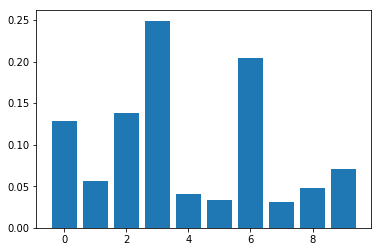

In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load the matrix with topic proportions for each document (note that this excludes those in the dev set).
npz = np.load(os.path.join('output', 'theta.train.npz')) 
ids = npz['ids']
theta = npz['theta']
n_docs, n_topics = theta.shape

index = 1
# plot the proportion of each topic in the first document
fig, ax = plt.subplots()
ax.bar(range(n_topics), theta[index, :])

# find the original line corresponding to this document, and display the text
print(ids[index])
for line in lines:
    doc = json.loads(line)
    if doc['id'] == ids[index]:
        print(doc['text'])
        break


This seems about right! The press release is mostly about veterans (topic 3), but also about spending (topic 6), with some amount of energy (topic 0) and infrastructure (topic 2).

Now, let's plot the relative prevalance of each topics for each Senator.

Because scholar split the training data into a training set and a dev set, we need to match up the output to the original senator variables.

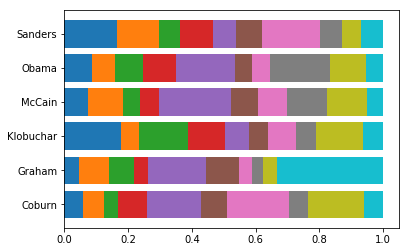

In [31]:

# load the senator variable for all the documents
senators_df = pd.read_csv(os.path.join('tutorial', 'congress', 'train.senator.csv'), header=0, index_col=0)
senators = senators_df.columns

# pull out a subset corresponding to the ids from above
train_subset = senators_df.loc[ids]
n_docs, n_senators = train_subset.shape

# plot the average senator-topic proportions
fig, ax = plt.subplots()
lefts = np.zeros(n_senators)
for k in range(n_topics):
    vals = []
    for senator in senators:
        vals.append(np.mean(theta[train_subset[senator] == 1, k]))

    ax.barh(range(n_senators), vals, left=lefts)
    lefts += np.array(vals)
    
ax.set_yticks(range(n_senators))
ax.set_yticklabels(senators)
plt.show();

This seems to have at least some face validity, with, for example, Amy Klobuchar writing more about energy/environment/infrastructure issues (topics 0 and 2), but more expertise would be useful in exploring this further. 

## Initializing with pretrained word vectors

Emperically, we found that initializing the model with pretrained word vectors led to greater coherence in the topics. If you are interested in trying this, it is necessary to download the pretrained word2vec vectors from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

Once this is done, and these have been saved somewhere, we can add the `--w2v` option to the model, with a path to the vector file. Here, we'll assume it's in the local directory.

Note that it takes some time to load the word vectors, so we'll just try this once for illustration purposes.

In [37]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator --w2v ./vectors/GoogleNews-vectors-negative300.bin'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator --w2v ./vectors/GoogleNews-vectors-negative300.bin
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.senator.csv
Computing background frequencies
Min/max word counts in training data: 88 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 6
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Loading word vectors
Found embeddings for 1012 words
Optimizing full model
Epoch: 10 cost= 1128.703389349
Epoch: 10; Dev perplexity = 840.9305
Epoch: 20 cost= 1130.367685612
Epoch: 20; Dev perplexity = 687.7510
Epoch: 30 cost= 1083.127119162
Epoch: 30; Dev perplexity = 632.9374
Epoch: 40 cost= 1075.399669673
Epoch: 40; Dev perplexity = 611.5000
Epoch: 50 cost=

In [38]:
beta = np.load('output/beta.npz')['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: veterans members guard service care benefits men soldiers ; sparsity=0.0000
1: court rights democratic supreme judge judiciary freedom united ; sparsity=0.0000
2: lead children tax illegal immigration insurance millions pay ; sparsity=0.0000
3: departments grants fire share awarded assistance local receive ; sparsity=0.0000
4: projects energy development environment million farmers transportation renewable ; sparsity=0.0000
5: going court right little things always something let ; sparsity=0.0000
6: announced investigation letter record press relases releases statement ; sparsity=0.0000
7: iraq troops war iraqi political terror win security ; sparsity=0.0000
8: statement following released julian tommy barack washington nomination ; sparsity=0.0000
9: energy oil gas renewable reduce prices sources climate ; sparsity=0.0000


In this case, the results seem quite similar, but it might be more beneficial when working with a larger vocabualry (and therefore words which occur less frequently).

## Adding more covariates

Note that we can easily include additional covarites in the same way as we did for senators. Let's try also including covariates for year and month. Just include them in a comma-separated list (again, without spaces).

In [35]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator,year,month'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator,year,month
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.senator.csv
Loading covariates from tutorial/congress/train.year.csv
Loading covariates from tutorial/congress/train.month.csv
Computing background frequencies
Min/max word counts in training data: 88 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 22
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 cost= 1129.572934144
Epoch: 10; Dev perplexity = 860.8310
Epoch: 20 cost= 1091.396167593
Epoch: 20; Dev perplexity = 766.9607
Epoch: 30 cost= 1087.384221634
Epoch: 30; Dev perplexity = 714.8554
Epoch: 40 cost= 1053.508688566
Epoch: 40; Dev perplexity = 6

Now if we load the covariate vectors, we will also see some temporal patterns in word frequencies. The ones here don't seem all that compelling, but perhaps more data is needed.

In [36]:
topic_covars = np.load(os.path.join('output', 'beta_c.npz'))
weights = topic_covars['beta']
names = topic_covars['names']
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

Coburn: room citizen coburn tom per released spending added ; sparsity=0.0000
Graham: bishop graham relases kevin lindsey south hickman carolina ; sparsity=0.0000
Klobuchar: klobuchar minnesota consumer secured guard serves farm transportation ; sparsity=0.0000
McCain: mccain john record browse freedom remains air democracy ; sparsity=0.0000
Obama: obama julian illinois barack brundage dick alerts gibbs ; sparsity=0.0000
Sanders: sanders http bernie sen vermont read paying told ; sparsity=0.0000
2005: gibbs julian vietor announces green tommy robert court ; sparsity=0.0000
2006: vietor tommy gibbs robert julian alternative green authority ; sparsity=0.0000
2007: labolt ben brundage amy http iraq course visit ; sparsity=0.0000
2008: newsletters petitions polls initiated michael alerts ortiz pursuant ; sparsity=0.0000
Apr: april location temporary drug prices price calls attention ; sparsity=0.0000
Aug: august transportation insurance office children area receive letter ; sparsity=0.0000

## Interactions

Alternatively, we can include interactions between covariates and topics.

Here, let's try using a covariate for party membership, rather than for each Senator, and include interactions between topics and party. To do this, just include the `--interactions` options. We'll also use less topics, since we'll effectively be getting two versions of each (Democrat and Republican).

In [44]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 8 --epochs 150 --dev-folds 10 --seed 99 --topic-covars party --interactions'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 8 --epochs 150 --dev-folds 10 --seed 99 --topic-covars party --interactions
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.party.csv
Computing background frequencies
Min/max word counts in training data: 88 5075
Network architecture:
embedding_dim: 300
n_topics: 8
vocab_size: 1021
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 2
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: True
Optimizing full model
Epoch: 10 cost= 1158.523839485
Epoch: 10; Dev perplexity = 920.8193
Epoch: 20 cost= 1113.416789010
Epoch: 20; Dev perplexity = 803.6328
Epoch: 30 cost= 1108.656210675
Epoch: 30; Dev perplexity = 752.6608
Epoch: 40 cost= 1076.031638877
Epoch: 40; Dev perplexity = 684.2396
Epoch: 50 cost= 1097.876675668
Epoch: 50; Dev perplexity = 642.9678
Epoch: 60 cost= 1079.306651549
Epoch: 60; D

First, let's look at the vectors learned for each party, then the topics, then the interactions.

In [45]:
topic_covars = np.load(os.path.join('output', 'beta_c.npz'))
weights = topic_covars['beta']
names = topic_covars['names']
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

D: barack ortiz fuel illinois gibbs newsletters monday vietor ; sparsity=0.0000
R: releases announce carolina south kevin graham judiciary fire ; sparsity=0.0000


In [46]:
beta = np.load(os.path.join('output', 'beta.npz'))['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: immigration illegal temporary pursuant polls border opinion alerts ; sparsity=0.0000
1: dick durbin request individual disaster severe communications letter ; sparsity=0.0000
2: grants vehicles equipment fire tools energy departments supports ; sparsity=0.0000
3: iraq troops war say strategy let different things ; sparsity=0.0000
4: announces announced bishop development lindsey awarded minnesota hickman ; sparsity=0.0000
5: room lead products transparency coburn consumer spending citizen ; sparsity=0.0000
6: statement court nomination justice attorney following julian passing ; sparsity=0.0000
7: guard care health soldiers members returning duty mental ; sparsity=0.0010


In [47]:
interactions = np.load(os.path.join('output', 'beta_ci.npz'))
weights = interactions['beta']
names = topic_covars['names']
names = [str(k) + ':' + c for k in range(10) for c in names]
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

0:D: alerts petitions opinion polls newsletters electronic communications initiated ; sparsity=0.0000
0:R: immigration illegal border secure states laws reform trade ; sparsity=0.0000
1:D: durbin dick counties sincerely disaster illinois severe opinion ; sparsity=0.0000
1:R: almost act bills largest report manner mccain around ; sparsity=0.0000
2:D: gas technologies energy environment oil economy standard efficient ; sparsity=0.0000
2:R: grants awarded demint tools supports receive fire contributions ; sparsity=0.0000
3:D: sanders bernie warming vermont http read reality global ; sparsity=0.0000
3:R: terror political war strategy consequences win chance iraq ; sparsity=0.0000
4:D: minnesota klobuchar transportation environment secured works subcommittee line ; sparsity=0.0000
4:R: announces contact releases browse date relases carolina announced ; sparsity=0.0000
5:D: lead products consumer children commission safety practices industry ; sparsity=0.0000
5:R: coburn room spending debt e

The basic topics here are now perhaps less good, but the interaction do seem to capture something about how the different parties talk about certain issues. For example, for topic 0 (immigration), The Democrat version emphasizes public opinion, whereas the republican version is more about border security. More data (from all the senators) would give us a much better approxaimation of this.

## Adding labels

In addition to covariates, we can also introduce labels, which are predicted from the topics that are learned. Although they only introduce a subtle influence on the topic, we are effectively learning a classifier and a topic model simultaneously.

Here, let's try predicting the party of a press release from the topics. We'll also try using slightly more topics this time.

In [52]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 12 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator,month --label party'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 12 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator,month --label party
Loading data
Loaded 2483 documents with 1021 features
Found 2483 non-empty documents
Loading labels from tutorial/congress/train.party.csv
Found 2 labels
Loading covariates from tutorial/congress/train.senator.csv
Loading covariates from tutorial/congress/train.month.csv
Train label proportions: [0.54007249 0.45992751]
Computing background frequencies
Min/max word counts in training data: 88 5075
Network architecture:
embedding_dim: 300
n_topics: 12
vocab_size: 1021
label_type: None
n_labels: 2
n_prior_covars: 0
n_topic_covars: 18
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 ; cost = 1136.633699490 ; training accuracy (noisy) = 0.702013423
Epoch: 10; Dev perplexity = 909.2849; Dev accuracy = 0.7177
Epoch: 20 ; cost = 1095.048931898 ; training accuracy (noi

First let's look at the topics as usual

In [53]:
beta = np.load(os.path.join('output', 'beta.npz'))['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: troops iraq course strategy iraqi war forces tell ; sparsity=0.0000
1: members veterans care returning military service soldiers defense ; sparsity=0.0000
2: immigration border investigation information illegal accountability workers reports ; sparsity=0.0000
3: nomination statement position following supreme judge court wes ; sparsity=0.0000
4: court supreme judge justice judiciary election rules democratic ; sparsity=0.0000
5: students environment project river climate development education funding ; sparsity=0.0000
6: counties products disaster safety homes lead dick assistance ; sparsity=0.0000
7: energy gas renewable oil fuels fuel sources consumers ; sparsity=0.0000
8: awarded announces grant grants announce announced receive demint ; sparsity=0.0000
9: statement released following newsletters petitions initiated pursuant opinion ; sparsity=0.0000
10: priorities spending earmarks billion fiscal veto bills budget ; sparsity=0.0000
11: statement released following newsletters or

Now let's look at which topics predict Democrat vs Republican.

In [54]:
npz = np.load('output/topics_to_labels.npz')
probs = npz['probs']
label_names = npz['label']
n_topics, n_labels = probs.shape
print("Labels:", ' '.join([name for name in label_names]))
for k in range(n_topics):
    output = str(k) + ': '
    for i in range(n_labels):
        output += '%.4f ' % probs[k, i]
    print(output)


Labels: D R
0: 0.4957 0.5043 
1: 0.8430 0.1570 
2: 0.7062 0.2938 
3: 0.0118 0.9882 
4: 0.4418 0.5582 
5: 0.8312 0.1688 
6: 0.9481 0.0519 
7: 0.8732 0.1268 
8: 0.0095 0.9905 
9: 0.9101 0.0899 
10: 0.3079 0.6921 
11: 0.5719 0.4281 


These numbers show the probability (according to the model) that a document entirely about a single topic is from a Democrat vs a Republican. Of course, in practice, most documents will be represented as a mixture of topics, and both parties talk about all topics to some degree.

More expertise would be useful in trying to interpret whether the model is doing something reasonable here, but at least some parts seem to line up (e.g. Democrats talking more about veterans (topic 1) and Republicans talking more about spending (topic 11). As above, using data from more Senators would be very useful here.

Ultimately, exploration of different models is requried to figure out what is best for your application. Also, remember than trying a different random seed will give you different results.